# Very Blander 

## Mathematical Means to Unbiased Redistricting

### (using Metropolis-Hastings Markov Chain Monte Carlo Generated Probability Distributions)

---

## Applying the Model to North Carolina Data

### Data Sources

This version uses the voter tabulation district geographic boundaries from the 2012 census bureau files.
https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2012&layergroup=Voting+Districts for North Carolina.

The North Carolina State Assembly Redistricting website provided nearly all the remaining data. The voter tabulation district level population, voting age, democratic vs republican 2014 Senate votes as a proxy for democratic voter percentage:
https://www2.ncleg.net/RnR/Redistricting/BaseData2016

County to congressional district mappings:  
https://www.ncleg.net/GIS/Download/District_Plans/DB_2016/Congress/2016_Contingent_Congressional_Plan_-_Corrected/Reports/DistrictGeography/rptDandC.xlsx

For the counties that had two congressional districts, raw 2018 election result data from TheDataTrust.com was provided to us for academic research purposes.

To process the data from raw data sources into the models two input files (nodes.csv and edges.csv) SQL (SQL Server) programs were used. Those files are attached. A short batch file was used to run that SQL code. This was only tested on the Windows version of SQL Server. The batch file will probably need a little modification to run under Linux. The SQL code and raw data files are in the accompanying zip file.

### Required Libraries

Common python libraries (NumPy, tqdm, Matplotlib) are required to run most of this code. If you don't need a nice progress bar, calls to tqdm/tqdm_notebook can be replaced with the embedded range().

In addition, to generate the maps, PyShp must be installed and in the NC Data, NetworkX is used to detect disconnected congressional districts.

In [25]:
# Sampling hyperparameters
m=5000
beta=.0002
c_pop=1/5000.
c_compact=2000
lambd=.1
sample_cnt=30

In [26]:
def Get_Colors(data):
    CD_Color=dict()
    for CD,row in data.iterrows():
        ratio=row['GOP_Votes']/(row['Dem_Votes']+row['GOP_Votes'])
        if ratio>=.7:
            R,G,B=128-(1-ratio)*100*(32/30),0,0
        elif ratio>=.6:
            R,G,B=255-(.7-ratio)*10*127,0,0
        elif ratio>=.55:
            R,G,B=255,128-(.6-ratio)*20*128,128-(.6-ratio)*20*128
        elif ratio>=.525:
            R,G,B=224+(.55-ratio)*40*31,64+(.55-ratio)*40*64,160-(.55-ratio)*40*32
        elif ratio>=.5:
            R,G,B=192+(.525-ratio)*40*32,(.525-ratio)*40*64,192-(.525-ratio)*40*32
        elif ratio>=.475:
            R,G,B=160+(.5-ratio)*40*32,128-(.5-ratio)*40*128,224-(.5-ratio)*40*32
        elif ratio>=.45:
            R,G,B=96+(.475-ratio)*40*64,160-(.475-ratio)*40*32,255-(.475-ratio)*40*31
        elif ratio>=.4:
            R,G,B=(.45-ratio)*20*96,(.45-ratio)*20*160,224+(.45-ratio)*20*31
        elif ratio>=.3:
            R,G,B=0,0,128+(.4-ratio)*10*96
        else:
            R,G,B=0,0,96+(.3-ratio)*100*(32/30)
        CD_Color[CD+1]="#%0.2X" % int(round(R,0)) + "%0.2X" % int(round(G,0)) + "%0.2X" % int(round(B,0))
    return CD_Color

def Election_Results(vtd):
    results = vtd.groupby(['Congressional_District'])[['Dem_Votes','GOP_Votes']].sum().reset_index()
    return sum([1 if row['Dem_Votes']>row['GOP_Votes'] else 0 for _, row in results.iterrows()])

def plot_map(data, shapefile, border_precinct_pairs, iteration):

    #Democrat metrics
    election_results = data.groupby(['Congressional_District'])[['Dem_Votes','GOP_Votes']].sum().reset_index()
    CD_Election_Red_Blue_Colors = Get_Colors(election_results)
    Dem_CDs=sum([1 if row['Dem_Votes']>row['GOP_Votes'] else 0 for _, row in election_results.iterrows()])
    
    %matplotlib inline
    from matplotlib.pyplot import show, figure, fill, axis, text, plot
    figure(figsize=(17,.05))
    axis('off')
    if iteration==0:
        title='North Carolina 2016 Congressional Districts'
    else:
        title='North Carolina Iteration '+str(iteration)+' of Hypothetical Redistricting'
    text(0.45,0,title,ha='center',va='center', fontsize=24)
    show()
    
    figure(figsize=(17,.05))
    axis('off')

    text(.45,1,'Democrat Seats Won (out of 13): %s'%Dem_CDs,ha='center',va='center', fontsize=20)
    show()
    figure(figsize=(40,12))
    #draw GOP/Dem ratio-colored congressional districts and their precincts  
    for shape in shapefile.shapeRecords():
        x = [i[0] for i in shape.shape.points[:]]
        y = [i[1] for i in shape.shape.points[:]]

        CD = data.loc[data.index==shape.record[3],'Congressional_District'].values[0]
        fill(x,y,color=CD_Election_Red_Blue_Colors[CD])
        plot(x,y,color='#373737',linewidth=.5,linestyle='dotted')
    #Draw exterior of congressional districts
    border_precincts=set()
    border_points=dict()
    for i in range(len(border_precinct_pairs)):
        border_precincts.add(border_precinct_pairs[i][0][0])
        border_precincts.add(border_precinct_pairs[i][1][0])
    shprecords=shapefile.records()
    shpshapes=shapefile.shapes()
    for i in range(len(shprecords)):
        if shprecords[i][3] in border_precincts:
            border_points[shprecords[i][3]]={point:None for point in shpshapes[i].points}

    for border_precinct_pair in border_precinct_pairs:
        border_point_x=list()
        border_point_y=list()
        for precinct0_point in border_points[border_precinct_pair[0][0]].keys():
            if precinct0_point in border_points[border_precinct_pair[1][0]].keys():
                border_point_x.append(precinct0_point[0])
                border_point_y.append(precinct0_point[1])
        plot(border_point_x,border_point_y,color='black',linewidth=2)
    show()

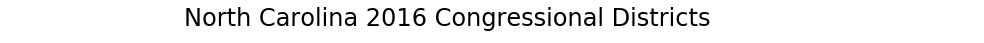

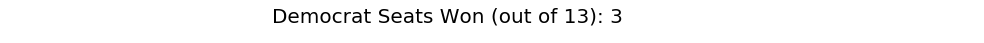

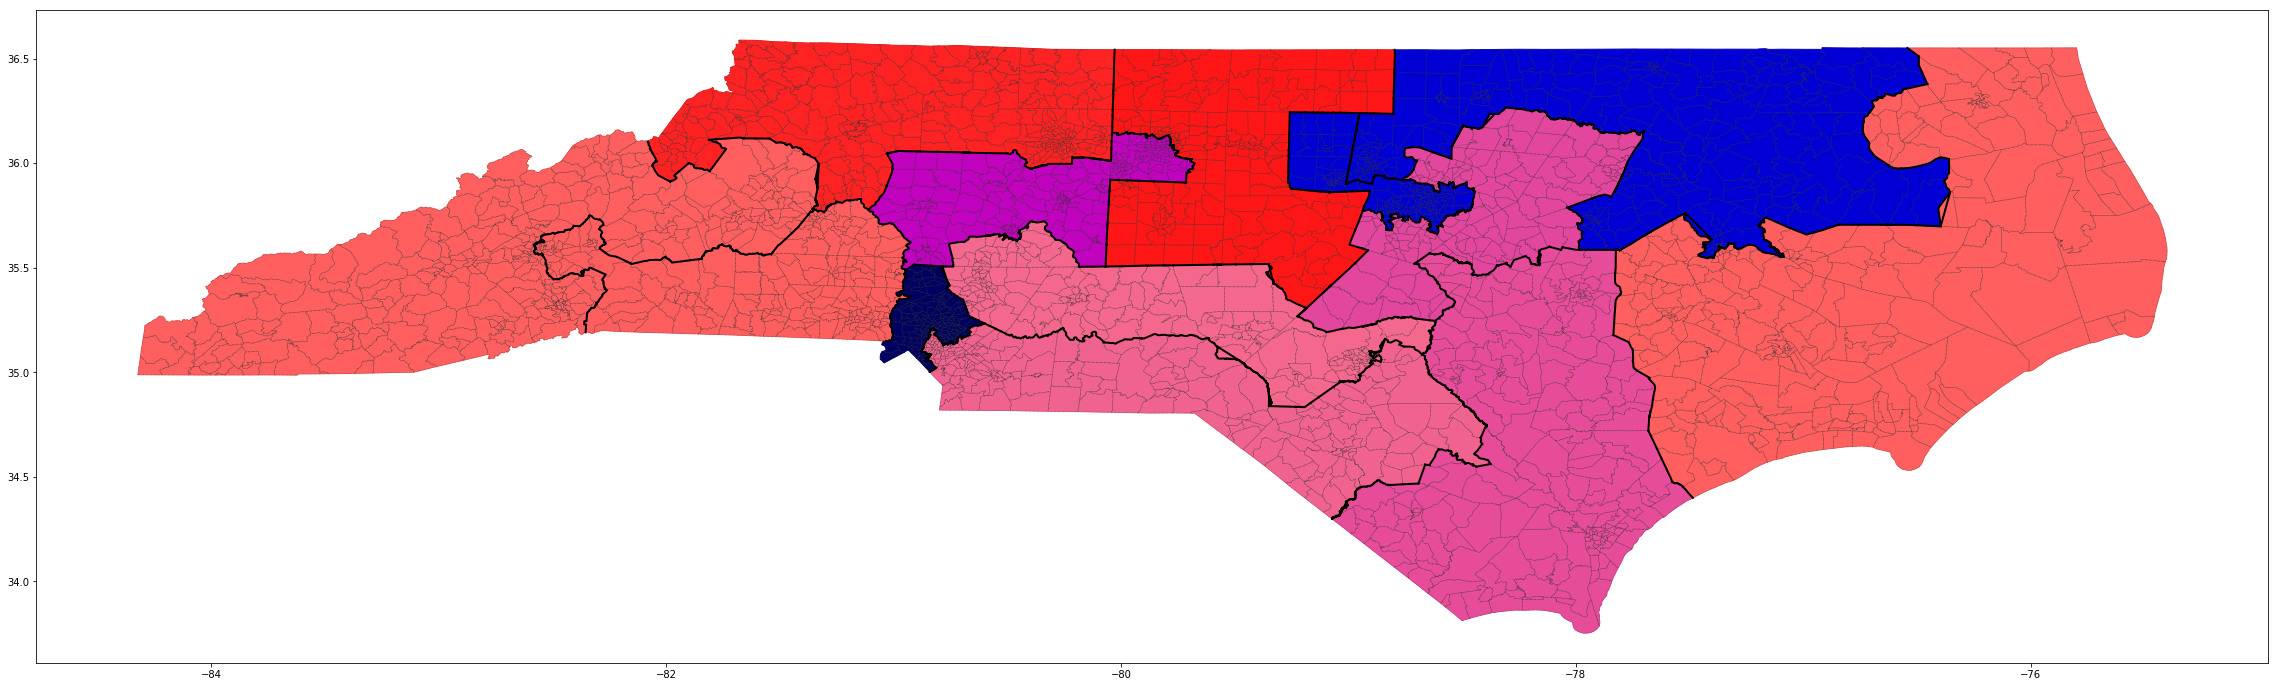

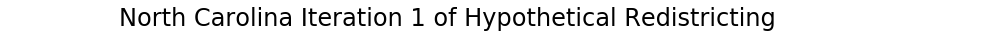

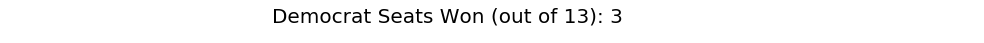

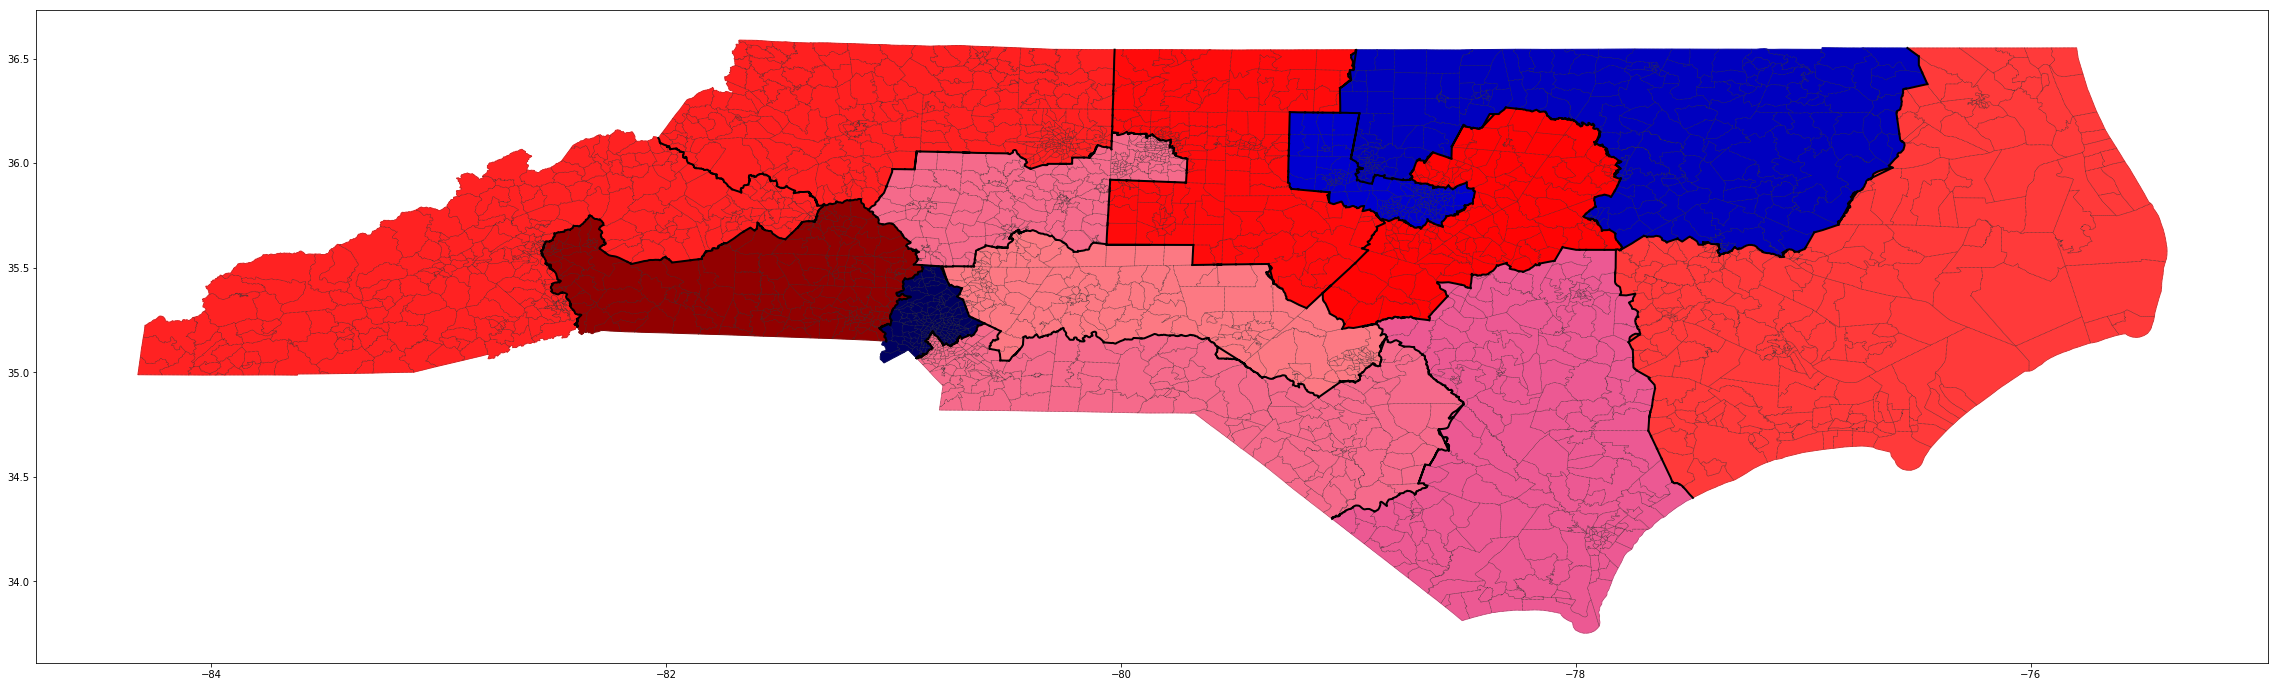

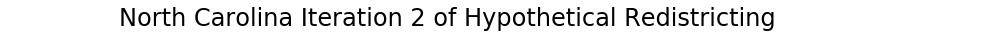

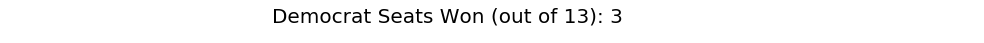

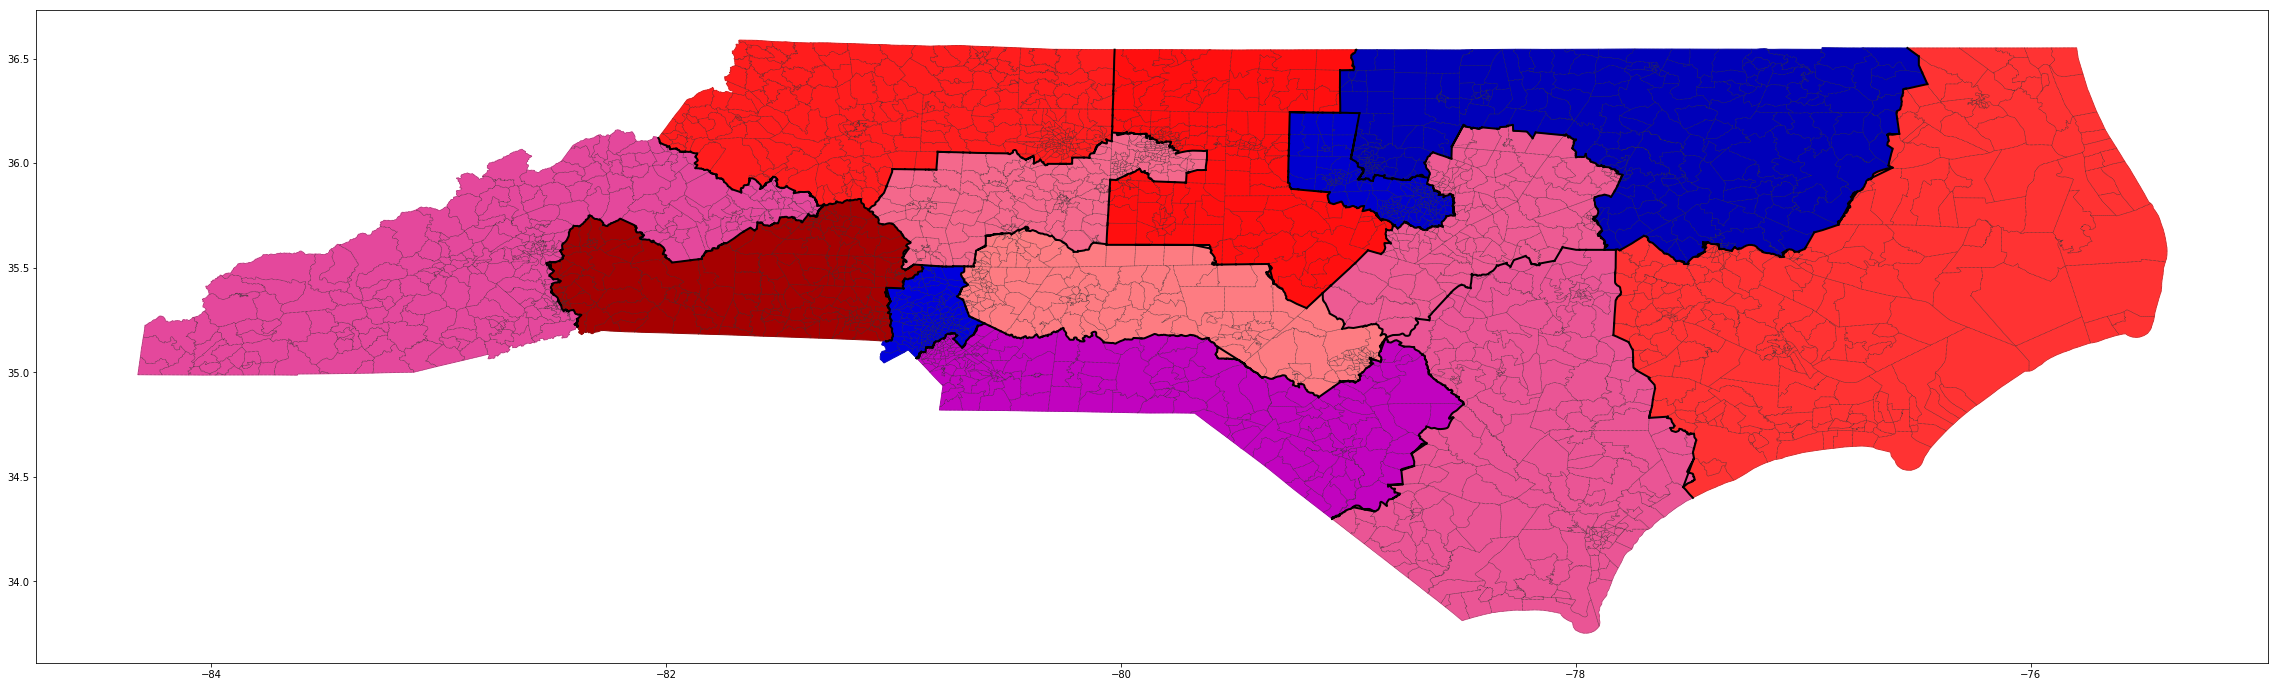

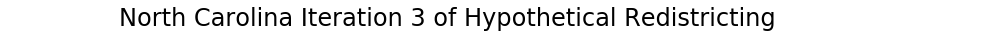

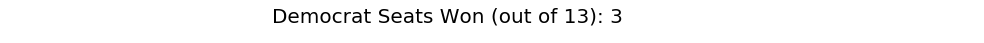

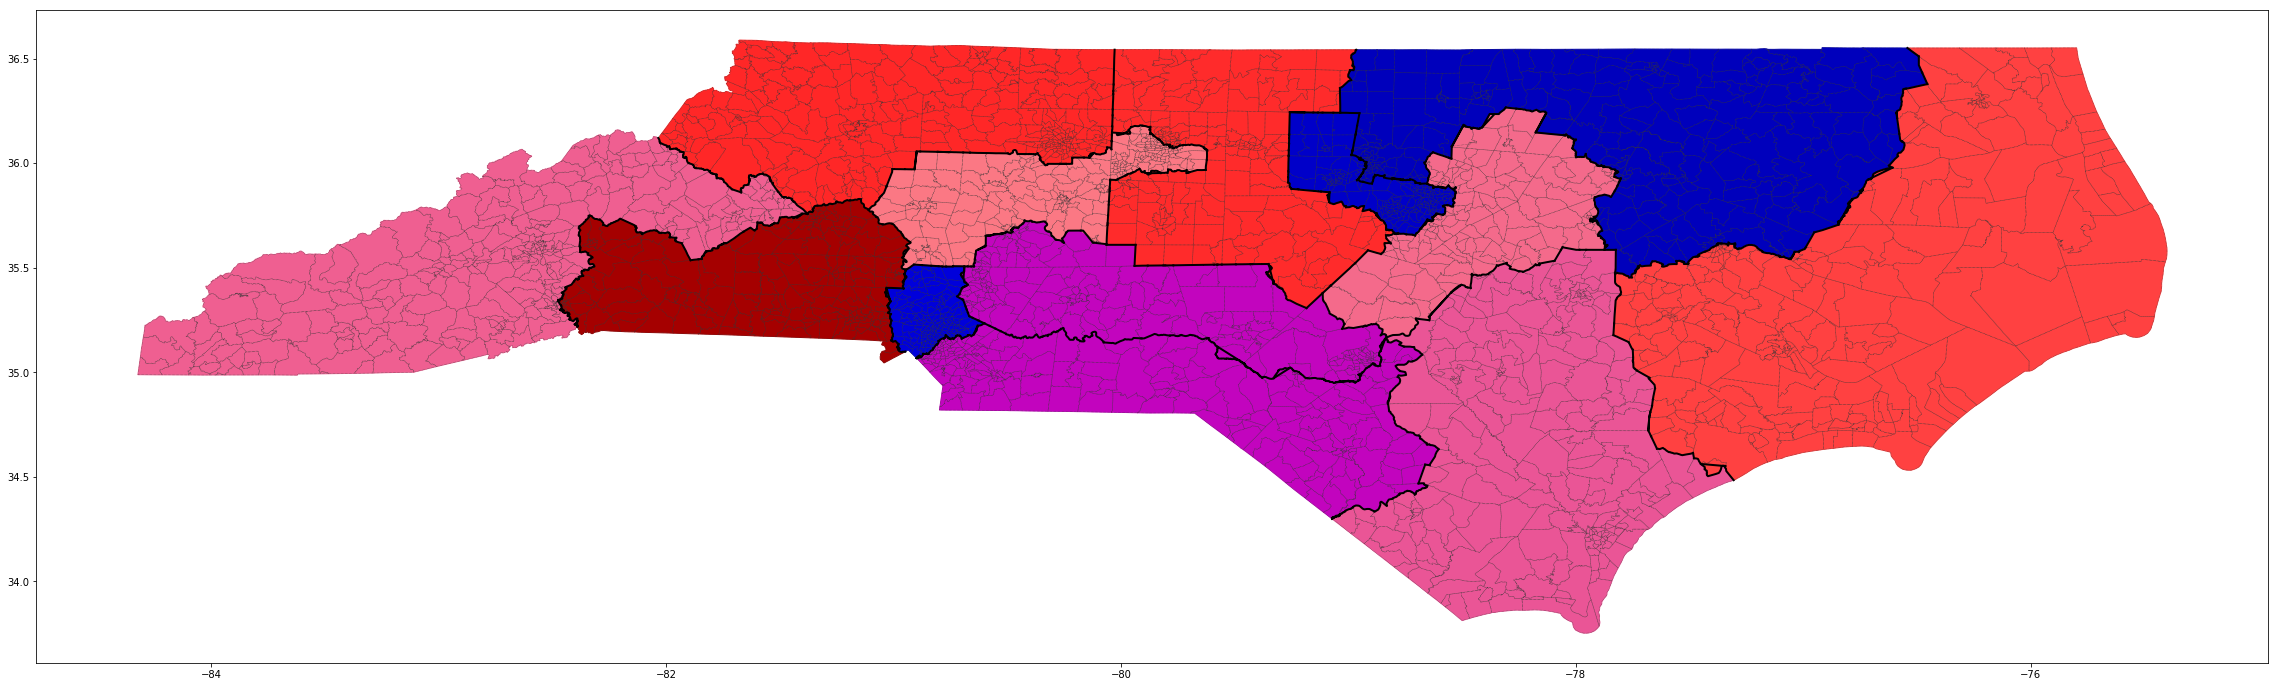

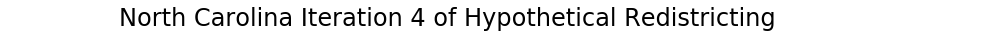

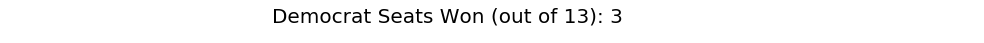

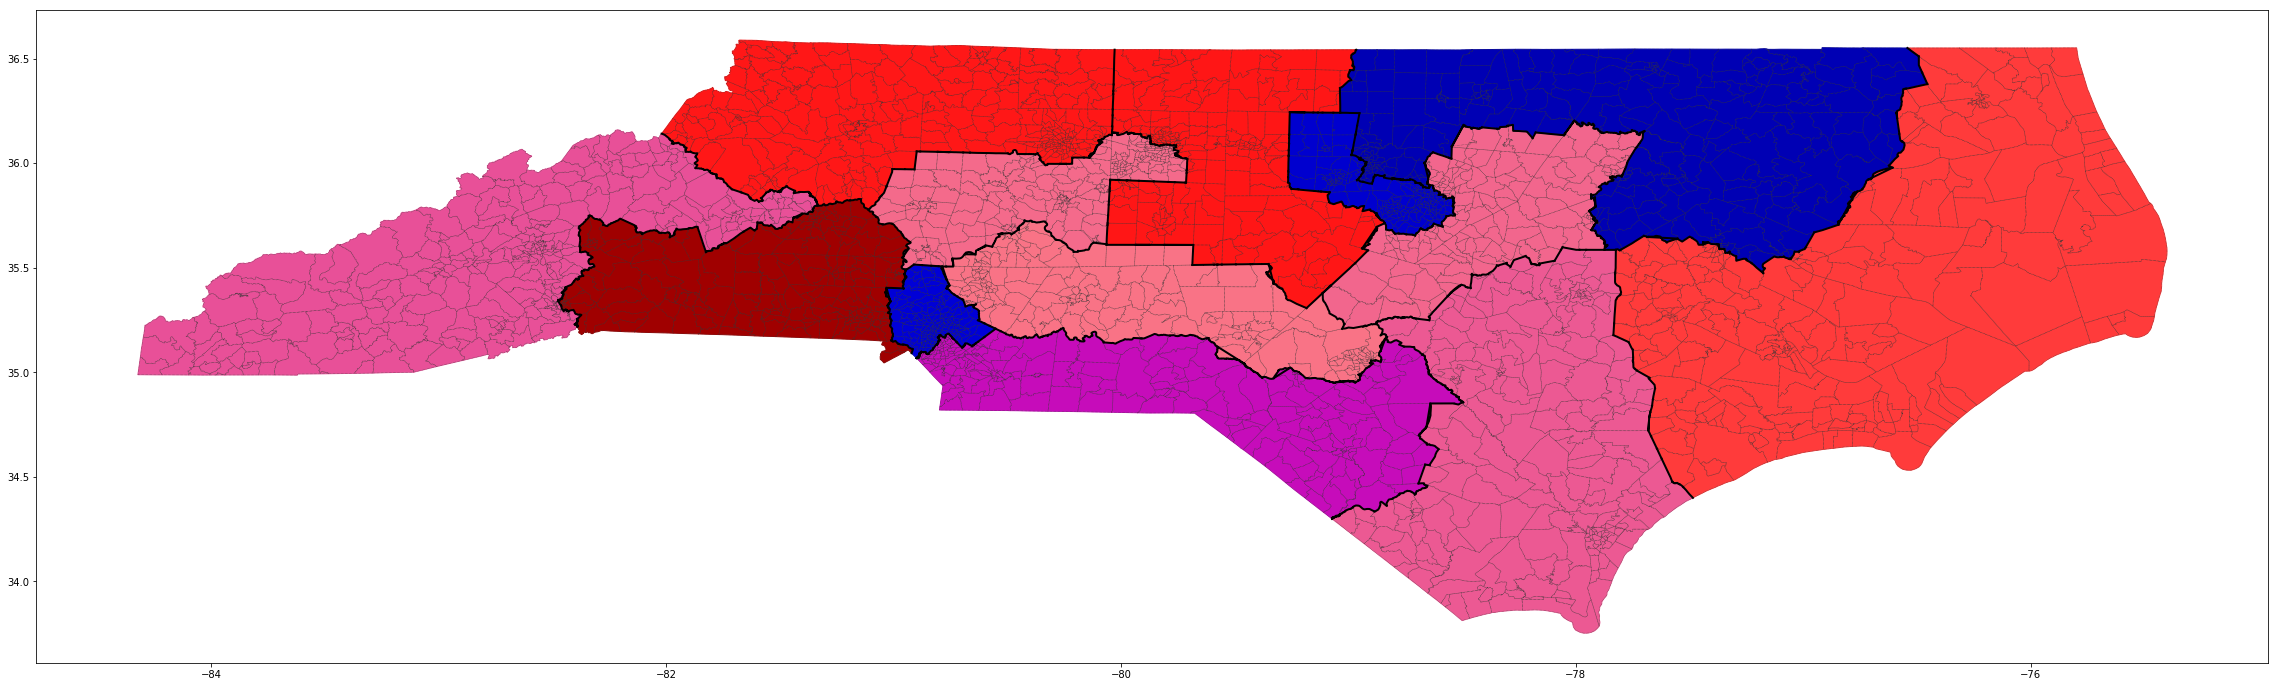

In [ ]:
from time import time
from pandas import read_csv
VTD_Nodes = read_csv('node.csv')
VTD_Nodes.set_index('GeoId',inplace=True)
from networkx import Graph
Congressional_District_Graph={CD:Graph() for CD in set(VTD_Nodes.Congressional_District)}
from networkx.convert_matrix import from_pandas_edgelist
VTD_Graph = from_pandas_edgelist(read_csv('edge.csv'),source='From_GeoId',target='To_GeoId',edge_attr='Miles_of_Common_Border')
CD_Border = list()
for u,v,border_length in VTD_Graph.edges.data('Miles_of_Common_Border'):
    u_cd=VTD_Nodes.loc[u,'Congressional_District']
    v_cd=VTD_Nodes.loc[v,'Congressional_District']
    if u_cd!=v_cd:
        CD_Border.append(((u,u_cd,v_cd,border_length),
                          (v,v_cd,u_cd,border_length)))
    else:
        Congressional_District_Graph[u_cd].add_edge(u,v)
sampled=0
from numpy.random import randint, seed, uniform
seed(42)
CD_Count=len(set(VTD_Nodes.Congressional_District))
from networkx import is_connected
from numpy import zeros, exp

Congressional_District_Boundary=zeros(CD_Count)
CD_Miles = VTD_Nodes.groupby(['Congressional_District'])[['Land_Square_Miles','State_Border_Miles']].sum().reset_index()
CD_Miles.set_index('Congressional_District',inplace=True)
for i in range(len(CD_Border)):
    Congressional_District_Boundary[CD_Border[i][0][1]-1]+=CD_Border[i][0][3]
    Congressional_District_Boundary[CD_Border[i][1][1]-1]+=CD_Border[i][1][3]
for CD, row in CD_Miles.iterrows():
    Congressional_District_Boundary[CD-1]+=row['State_Border_Miles']
Pop_Score = VTD_Nodes.groupby(['Congressional_District'])[['Population']].sum().reset_index().loc[:,'Population'].var()*(CD_Count-1)
Geog_Score=0
for CD, Perimeter in enumerate(Congressional_District_Boundary):
    Geog_Score+=Perimeter**2/CD_Miles.loc[CD+1].Land_Square_Miles
Current_Score=lambd*c_pop*Pop_Score+(1-lambd)*c_compact*Geog_Score
Redistrictings=list()
accepted_redistricting=0
samples=list()
from shapefile import Reader
VTD_Map = Reader('tl_2012_37_vtd10.shp')
plot_map(VTD_Nodes, VTD_Map, CD_Border, 0)

from tqdm import tqdm_notebook
from copy import deepcopy
for iteration in range(1,sample_cnt+1):
    current_beta=beta
    for n in tqdm_notebook(range(m)):
        if n>m/2:
            current_beta=beta*10
        deleted_border_list=set()
        added_border_list=set()
        CD_Border_Index=randint(len(CD_Border))
        flippable_vtd, old_cd, new_cd, _ = CD_Border[CD_Border_Index][randint(2)]
        
        # CD_Border, Congressional_District_Graph and VTD_Nodes get modified by CD changes
        Congressional_District_Graph[old_cd].remove_node(flippable_vtd)
        #Disconnected Congressional Districts are not allowed
        if is_connected(Congressional_District_Graph[old_cd]):
 
            for neighbor in VTD_Graph.neighbors(flippable_vtd):
                oth_cd=VTD_Nodes.loc[neighbor,'Congressional_District']
                if oth_cd==new_cd:
                    Congressional_District_Graph[new_cd].add_edge(flippable_vtd, neighbor)
                elif oth_cd==old_cd:
                    border_length=VTD_Graph.edges[flippable_vtd,neighbor]['Miles_of_Common_Border']
                    added_border_list.add(((flippable_vtd, new_cd, oth_cd, border_length),(neighbor, oth_cd, new_cd, border_length)))
                else:
                    border_length=VTD_Graph.edges[flippable_vtd,neighbor]['Miles_of_Common_Border']
                    added_border_list.add(((flippable_vtd, new_cd, oth_cd, border_length),(neighbor, oth_cd, new_cd, border_length)))
            for key in deleted_border_list:
                CD_Border.remove(key)
            border_cnt=len(CD_Border)
            for i in range(border_cnt-1,-1,-1):
                if CD_Border[i][0][0]==flippable_vtd or CD_Border[i][1][0]==flippable_vtd:
                    deleted_border_list.add(CD_Border[i])
                    del CD_Border[i]
            for key in added_border_list:
                CD_Border.append(key)
            
            VTD_Nodes.loc[flippable_vtd,'Congressional_District']=new_cd

            #Recalculate Geography and Population Scores
            Congressional_District_Boundary=zeros(CD_Count)
            CD_Miles = VTD_Nodes.groupby(['Congressional_District'])[['Land_Square_Miles','State_Border_Miles']].sum().reset_index()
            CD_Miles.set_index('Congressional_District',inplace=True)
            for i in range(len(CD_Border)):
                Congressional_District_Boundary[CD_Border[i][0][1]-1]+=CD_Border[i][0][3]
                Congressional_District_Boundary[CD_Border[i][1][1]-1]+=CD_Border[i][1][3]
            for CD, row in CD_Miles.iterrows():
                Congressional_District_Boundary[CD-1]+=row['State_Border_Miles']
            Geog_Score=0
            for CD, Perimeter in enumerate(Congressional_District_Boundary):
                Geog_Score+=Perimeter**2/CD_Miles.loc[CD+1].Land_Square_Miles
            Pop_Score = VTD_Nodes.groupby(['Congressional_District'])[['Population']].sum().reset_index().loc[:,'Population'].var()*(CD_Count-1)
            New_Score=lambd*c_pop*Pop_Score+(1-lambd)*c_compact*Geog_Score
            
            #MH-MCMC sample exclusion test
            if min(1, exp(-current_beta*(New_Score - Current_Score))) < uniform():
                #put everything back to state before this district change
                VTD_Nodes.loc[flippable_vtd,'Congressional_District']=old_cd
                Congressional_District_Graph[new_cd].remove_node(flippable_vtd)
                for neighbor in VTD_Graph.neighbors(flippable_vtd):
                    if VTD_Nodes.loc[neighbor,'Congressional_District']==old_cd:
                        Congressional_District_Graph[old_cd].add_edge(flippable_vtd, neighbor)
                for key in deleted_border_list:
                    CD_Border.append(key)
                for key in added_border_list:
                    CD_Border.remove(key)
            else:
                Current_Score=New_Score
                accepted_redistricting+=1
        else:
            for neighbor in VTD_Graph.neighbors(flippable_vtd):
                if old_cd==VTD_Nodes.loc[neighbor,'Congressional_District']:
                    Congressional_District_Graph[old_cd].add_edge(flippable_vtd, neighbor)
    
    plot_map(VTD_Nodes, VTD_Map, CD_Border, iteration)
    samples.append(deepcopy(VTD_Nodes))
print('sampling acceptance rate: %s for lambda: %s and beta: %s',(accepted_redistricting/sample_cnt*m,lambd,beta))

Dem_Seats=list()
from numpy import mean
for sample in samples:
    Dem_Seats.append(Election_Results(sample))
%matplotlib inline
from matplotlib.pyplot import hist, title, xlabel, ylabel, show
hist(Dem_Seats)
title('North Carolina 2016 Democrat Winners')
ylabel('Redistricting Samples')
xlabel('Number of Democratic House Seats')
show()